# Import Modules

In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as stats
import geopandas as gpd
from shapely.geometry import Point
import folium
import branca.colormap as cm

# Variables

In [2]:
# LANDSAT
LANDSAT_PATH_ORIGINAL = "data/modelling/baseline_datasets/20250610_landsat_bands_centre_only.txt" 
LANDSAT_PATH_DAYOF = "data/modelling/baseline_datasets/20250630_landsat_bands_centre_dayof.txt"
LANDSAT_PATH_EXTRA = "data/modelling/baseline_datasets/20250630_landsat_bands_centre.txt" 

LANDSAT_365DAYS = "data/modelling/365day_datasets/raw/20250803_landsat_bands_centre_32-365days.txt"

In [3]:
SOIL_PATH = "data/modelling/baseline_datasets/250627_lucas_2018_cleaned.csv"

## Load files

In [5]:
# Function to read text files as json
def read_txt_as_df(filepath):
    rows = []
    with open(filepath, 'r+') as f:
        for line in f:
            try: 
                data = json.loads(line)
                if isinstance(data, dict):
                    rows.append(data)
            except json.JSONDecodeError:
                continue

    # Convert to a dataframe
    df = pd.DataFrame(rows)
    return df

In [6]:
# Landsat
landsat_older = read_txt_as_df(LANDSAT_PATH_ORIGINAL)
landsat_extra = read_txt_as_df(LANDSAT_PATH_EXTRA)
landsat_dayof = read_txt_as_df(LANDSAT_PATH_DAYOF)
landsat_365 = read_txt_as_df(LANDSAT_365DAYS)

# Load soil dataframe
soil = pd.read_csv(SOIL_PATH)

In [7]:
landsat_365.to_csv("data/modelling/365day_datasets/raw/20250803_landsat_bands_centre_32-365days.csv")

### Join Dataframes & De-duplicate

In [8]:
# Concatenate all sentinel Dataframes
landsat_all = pd.concat([landsat_older, landsat_extra, landsat_dayof, landsat_365])

# Correct datetime format
landsat_all['survey_date'] = pd.to_datetime(landsat_all['survey_date'])
landsat_all['image_date'] = pd.to_datetime(landsat_all['image_date'])

# Calculate days between survey and image date
landsat_all['days_diff'] = (landsat_all['survey_date'] - landsat_all['image_date']).dt.days

print(f"Length of joined dataframe: {len(landsat_all)}")

# Drop images taken on the same date for each point ID
landsat = landsat_all.drop_duplicates(subset=['point_id', 'image_date'], keep='last')
print(f"Length of de-duplicated dataframe: {len(landsat)}")

Length of joined dataframe: 565360
Length of de-duplicated dataframe: 463694


## Remove Null Rows

In [9]:
print(f"Length of landsat dataframe: {len(landsat)}")

# Drop nulls
landsat = landsat.dropna(axis=0)
print(f"Length after removing nulls: {len(landsat)}")

Length of landsat dataframe: 463694
Length after removing nulls: 462339


## Decode Cloud Pixel Values

In [10]:
# Function to decode values
def decode_qa_pixel(value):
    if value is None:
        return {}
    
    return {
        "fill": bool(value & (1 << 0)),
        "dilated_cloud": bool(value & (1 << 1)),
        "cirrus": bool(value & (1 << 2)),
        "cloud": bool(value & (1 << 3)),
        "cloud_shadow": bool(value & (1 << 4)),
        "snow": bool(value & (1 << 5)),
        "clear": bool(value & (1 << 6)),
        "water": bool(value & (1 << 7)),
        "cloud_confidence": int((value >>8) & 0b11),
        "cloud_shadow_confidence": int((value >> 10) & 0b11),
        "snow_ice_confidence": int((value >> 12) & 0b11),
        "cirrus_confidence": int((value >> 14) & 0b11)
    }

In [11]:
# Convert QA_PIXEL to an int value and rename
landsat['QA_PIXEL'] = landsat['QA_PIXEL'].astype(int)
landsat = landsat.rename(columns={'QA_PIXEL': 'QA_PIXEL_BIT'})

# Decode the pixel 
landsat['QA_PIXEL'] = landsat['QA_PIXEL_BIT'].apply(lambda x: decode_qa_pixel(x))
cloud_properties = pd.json_normalize(landsat['QA_PIXEL'])
cloud_properties = cloud_properties.reset_index().drop(columns='index')
landsat = landsat.reset_index().drop(columns='index')

# Merge the two together
ls_merged = landsat.merge(cloud_properties, left_index=True, right_index=True).drop(columns=['QA_PIXEL_BIT', 
                                                                                        'cloud_confidence', 
                                                                                        'cloud_shadow_confidence',
                                                                                        'snow_ice_confidence', 
                                                                                        'cirrus_confidence'], errors='ignore')

## Cloud Analysis

In [13]:
df = ls_merged.copy()

In [14]:
# Ensure datetime columns are in the correct format
df['survey_date'] = pd.to_datetime(df['survey_date'])
df['image_date'] = pd.to_datetime(df['image_date'])

### Get the Most Recent Image DF

In [15]:
# Create a dataframe with most recent images and calculate the days between this and survey date
df['days_diff'] = (df['survey_date']-df['image_date']).dt.days
recent_df = df.loc[df.groupby('point_id')['days_diff'].idxmin()].copy()

In [16]:
print(f"Number of most recent images: {len(recent_df)}")

Number of most recent images: 15977


### Bar Chart of True Values for QA_PIXEL Bands

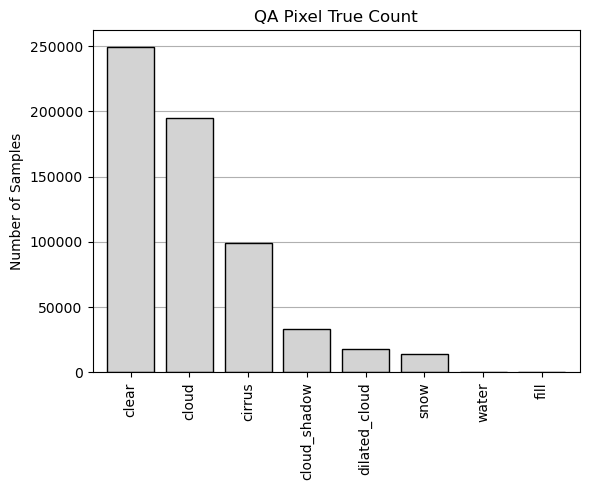

In [17]:
qa_cols = ['fill', 'dilated_cloud', 'cirrus', 'cloud', 'cloud_shadow', 'snow', 'clear', 'water']

# Count by how many are true
true_counts = df[qa_cols].sum().sort_values(ascending=False)

width=6
height=5
fig, ax = plt.subplots()
true_counts.plot(kind="bar", figsize=(width,height), 
                 title="QA Pixel True Count", color='lightgrey', edgecolor='black', width=0.8)
plt.ylabel("Number of Samples")
plt.grid(True, axis='y')  # Enable horizontal grid
ax.set_axisbelow(True)
plt.tight_layout()
plt.savefig('./graphs/landsat/qapixel_truecount_bar.png', dpi=300)
plt.show()

### Which samples have true for multiple features

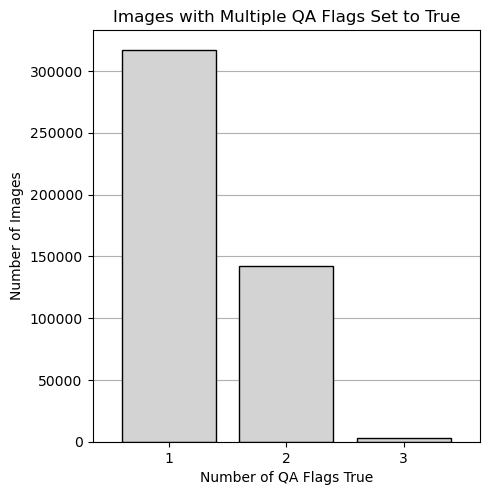

In [18]:
df['n_true'] = df[qa_cols].sum(axis=1)

# Optional: see how many rows fall into each count of True flags
true_distribution = df['n_true'].value_counts().sort_index()
width = 5
height = 5
fig, ax = plt.subplots()
true_distribution.plot(kind='bar', figsize=(width, height),
                       color='lightgrey', edgecolor='black',
                       width=0.8)
plt.xlabel('Number of QA Flags True')
plt.ylabel('Number of Images')
plt.title('Images with Multiple QA Flags Set to True')
plt.grid(True, axis='y')  # Enable horizontal grid
ax.set_axisbelow(True)
plt.tight_layout()
plt.xticks(rotation=0)
plt.savefig('./graphs/landsat/qapixel_multipletrue_bar.png', dpi=300)
plt.show()

In [19]:
# Remove any with snow, water, fill
print(f"Length of dataframe: {len(df)}")
false_cols = ['snow', 'water', 'fill']
for col in false_cols:
    df = df[df[col]==False]
print(f"Length of dataframe after removing true: {len(df)}")


Length of dataframe: 462339
Length of dataframe after removing true: 447344


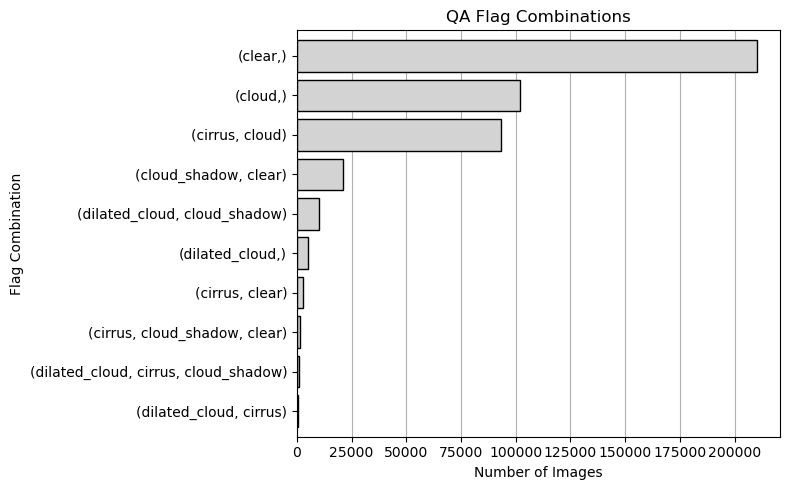

In [20]:
multi_true_df = df.copy()
multi_true_df['true_flags'] = multi_true_df[qa_cols].apply(lambda row: tuple(col for col in qa_cols if row[col]), axis=1)
true_combinations = multi_true_df['true_flags'].value_counts().reset_index()
true_combinations.columns = ['true_combo', 'count']

width = 8
height = 5
true_combinations.plot(kind='barh', x='true_combo', y='count', 
                       figsize=(width, height), 
                       legend=False, zorder=2,
                       color='lightgrey', edgecolor='black',
                       width=0.8)
plt.gca().invert_yaxis()
plt.title(f"QA Flag Combinations")
plt.xlabel("Number of Images")
plt.ylabel("Flag Combination")
plt.tight_layout()
plt.grid(axis='x', zorder=0)
plt.savefig('./graphs/landsat/qapixel_common_combos_barh.png', dpi=300)

plt.show()


## Process

* Replace (cirrus, cloud) with just cloud
* Replace all other columns with true for other values, with one column called "cloud effects" and set this to true

In [21]:
# Set cirrus to false if cirrus and cloud are true - essentially replacing with just cloud
df.loc[(df['cirrus']) & (df['cloud']), 'cirrus'] = False

# Create cloud eggects column which shows true if cirrus, cloud shadow or dilated cloud are true
df['cloud_effects'] = df[['cirrus', 'cloud_shadow', 'dilated_cloud']].any(axis=1)

# Drop columns
df = df.drop(columns=['cirrus', 'cloud_shadow', 'dilated_cloud', 'snow', 'water', 'fill'], errors='ignore')

In [22]:
# Drop other unuseful columns
df = df.drop(columns=["n_true", "image_id", "QA_PIXEL"])

In [23]:
len(df)

447344

# Save as CSV

In [24]:
# Save sentinel as CSV
LANDSAT_CSV_PROCESSED = "data/modelling/365day_datasets/processed/20250807_landsat_band_values_365days.csv"
df.to_csv(LANDSAT_CSV_PROCESSED, index=False)